In [2]:
using Test
using StaticArrays
using Random
using Plots
import Pkg
using Statistics

Pkg.activate(joinpath(@__DIR__, "../../"))
using segc_wl   # or the module name inside segc_wl.jl

  Activating project at `~/Documents/montecarlo/segc_wl`


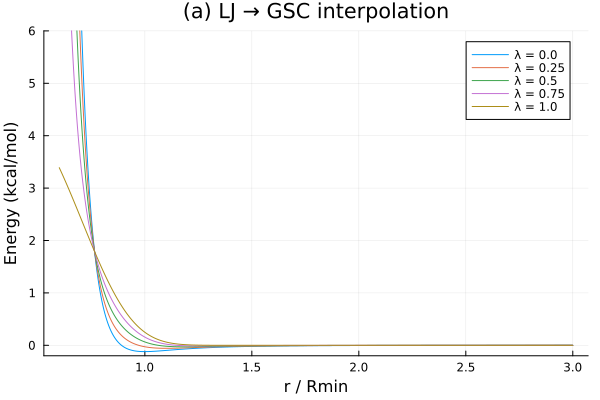

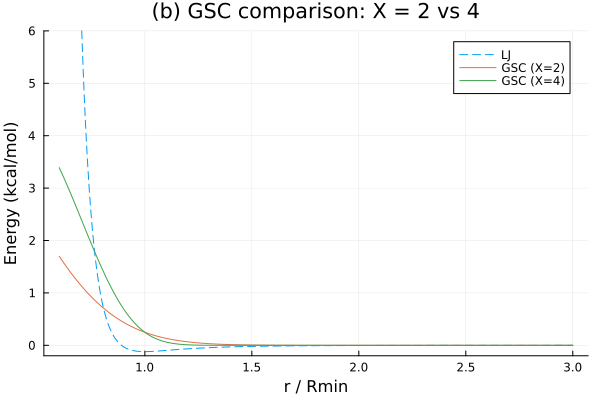

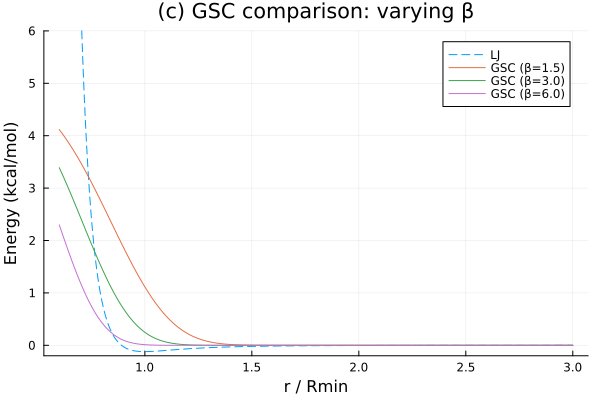

In [ ]:


# -----------------------------
# Parameters from paper
# -----------------------------
epsilon = 0.12      # kcal/mol (LJ well depth)
Rmin = 1.0          # reduced units
alpha = 5.0         # GSC height (kcal/mol)
beta_default = 3.0
X_default = 4

# r grid (avoid singularity at r=0)
r = range(0.6, 3.0, length=2000)

# -----------------------------
# Lennard-Jones potential
# U_LJ = ε [ (Rmin/r)^12 - 2(Rmin/r)^6 ]
# -----------------------------
U_LJ(r) = epsilon * ((Rmin ./ r).^12 .- 2 .* (Rmin ./ r).^6)

# -----------------------------
# Gaussian soft-core potential
# U_GSC = α exp( -β (r/Rmin)^X )
# -----------------------------
U_GSC(r; alpha=alpha, beta=beta_default, X=X_default) = alpha .* exp.(-beta .* (r ./ Rmin).^X)

# -----------------------------
# Panel (a): λ interpolation
# U(λ) = (1-λ)U_LJ + λU_GSC
# -----------------------------
lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]

p1 = plot(title="(a) LJ → GSC interpolation",
          xlabel="r / Rmin",
          ylabel="Energy (kcal/mol)",
          ylim=(-0.2, 6))

for λ in lambdas
    U_interp = (1-λ) .* U_LJ(r) .+ λ .* U_GSC(r)
    plot!(p1, r ./ Rmin, U_interp, label="λ = $λ")
end

# -----------------------------
# Panel (b): X = 2 vs 4
# -----------------------------
p2 = plot(title="(b) GSC comparison: X = 2 vs 4",
          xlabel="r / Rmin",
          ylabel="Energy (kcal/mol)",
          ylim=(-0.2, 6))

plot!(p2, r ./ Rmin, U_LJ(r), linestyle=:dash, label="LJ")

for X in [2, 4]
    U_gsc = U_GSC(r; X=X)
    plot!(p2, r ./ Rmin, U_gsc, label="GSC (X=$X)")
end

# -----------------------------
# Panel (c): varying β
# -----------------------------
p3 = plot(title="(c) GSC comparison: varying β",
          xlabel="r / Rmin",
          ylabel="Energy (kcal/mol)",
          ylim=(-0.2, 6))

plot!(p3, r ./ Rmin, U_LJ(r), linestyle=:dash, label="LJ")

for β in [1.5, 3.0, 6.0]
    U_gsc = U_GSC(r; beta=β)
    plot!(p3, r ./ Rmin, U_gsc, label="GSC (β=$β)")
end

# Display separately
display(p1)
display(p2)
display(p3)


In [4]:
function E12_frac_LJ_simple(rij_squared_σ,λ,λ_max)
    #= computes interaction between fractional particle and normal LJ particle according to equation 16 of Desgranges 2016. Note that `M` in Desgranges = λ_max + 1 in our notation
    returns energy in lennard jones units
    =# 
    rij_σ = sqrt(rij_squared_σ) # sqrt is unavoidable here I think 
    M = λ_max + 1
    ϵ_ξ = (λ/M)^(1/3) # fractional energy  coupling parameter in lennard jones units (so really this might be named ϵ_ξ_σ but that just looked like too much)
    σ_ξ = (λ/M)^(1/4) # \sigma_\xi is the fractional distance coupling parameter in LJ σ units  
    E_int = (σ_ξ/rij_σ)^12 - (σ_ξ/rij_σ)^6
    E_int = 4*ϵ_ξ*E_int
    return(E_int)

end #E12_frac_lj 

E12_frac_LJ_simple (generic function with 1 method)

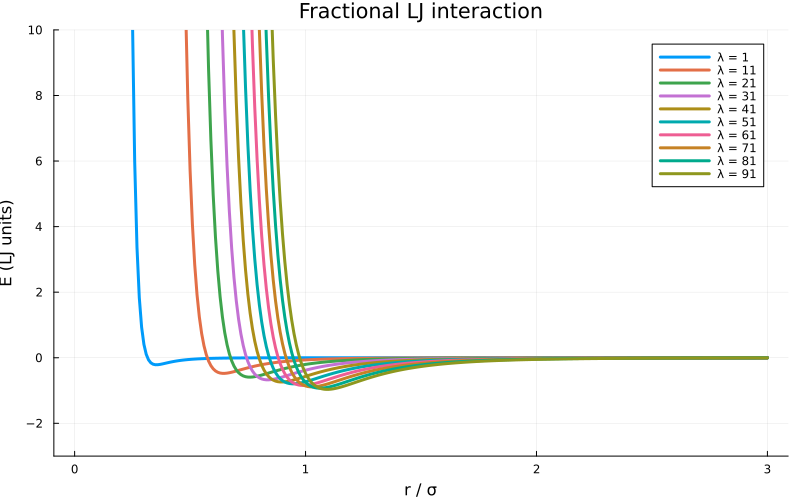

In [5]:
rs = 0:0.01:3
r2s = rs.^2

λ_max = 100
λ_values = 1:10:100

p = plot(
    xlabel = "r / σ",
    ylabel = "E (LJ units)",
    title = "Fractional LJ interaction",
    legend = :topright,
    ylim=(-3,10),
    size = (800, 500)
)

for λ in λ_values
    E = E12_frac_LJ_simple.(r2s, λ, λ_max)
    plot!(p, rs, E, label = "λ = $λ",lw=3)
end

display(p)

In [ ]:
function Lammps_LJ_softcore(r2, λ, λ_max)

    M = λ_max + 1
    s = λ / M

    r6 = r2^3

    E_int = 1 / (0.5*(1-s)^2 + r6)^2 - 1 / (0.5*(1-s)^2 + r6)

    return 4s * E_int
end


Lammps_LJ_softcore (generic function with 1 method)

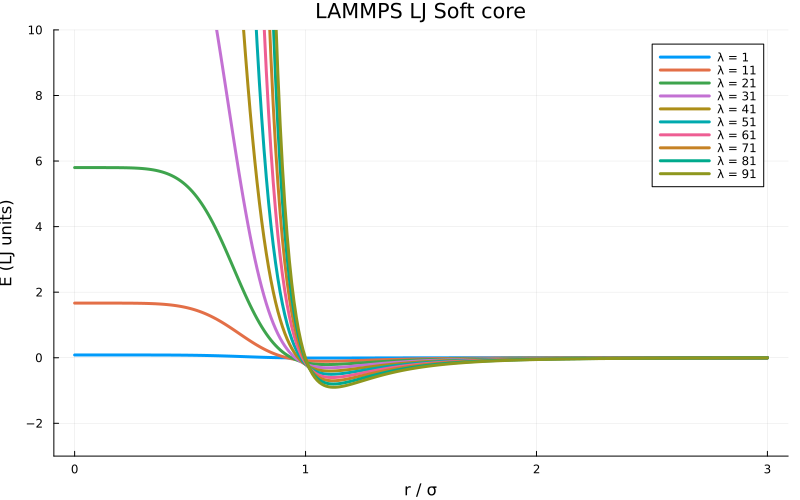

In [14]:
rs = 0:0.01:3
r2s = rs.^2

λ_max = 100
λ_values = 1:10:100

p = plot(
    xlabel = "r / σ",
    ylabel = "E (LJ units)",
    title = "LAMMPS LJ Soft core",
    legend = :topright,
    ylim=(-3,10),
    size = (800, 500)
)

for λ in λ_values
    E = Lammps_LJ_softcore.(r2s, λ, λ_max)
    plot!(p, rs, E, label = "λ = $λ",lw=3)
end

display(p)

In [16]:
function hybrid_frac_lammps(r, λ, λ_max)

    M = λ_max + 1
    s = λ / M

    

    E_int = 1 / (0.5*(1-s)^2 + (r/s)^12)^2 -
            1 / (0.5*(1-s)^2 + (r/s)^6)

    return 4s * E_int
end


hybrid_frac_lammps (generic function with 1 method)

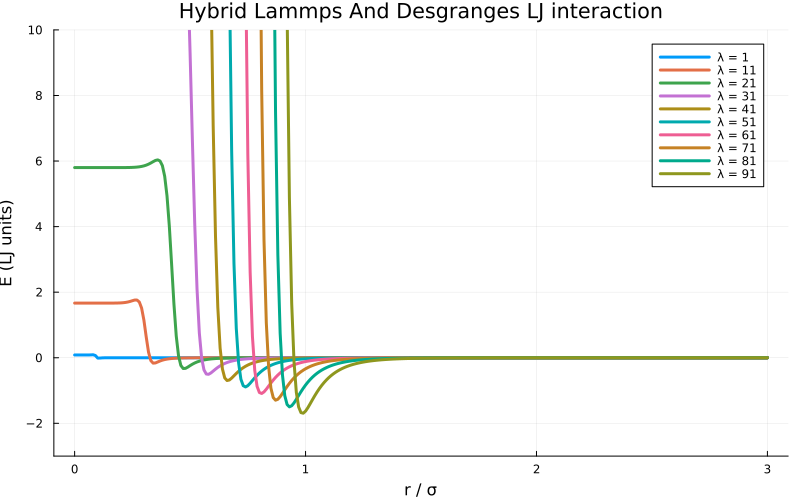

In [19]:
rs = 0:0.01:3
r2s = rs.^2

λ_max = 100
λ_values = 1:10:100

p = plot(
    xlabel = "r / σ",
    ylabel = "E (LJ units)",
    title = "Hybrid Lammps And Desgranges LJ interaction",
    legend = :topright,
    ylim=(-3,10),
    size = (800, 500)
)

for λ in λ_values
    E = hybrid_frac_lammps.(r2s, λ, λ_max)
    plot!(p, rs, E, label = "λ = $λ",lw=3)
end

display(p)